# Assistive Vision

The computer vision based assistive technology for the blind and visually impaired is a developing area. The assistive technology helps the visually impaired by providing them with a greater independence. By enabling them with their day-to-day activities like indoor and outdoor navigation, obstacle detection, locating the doors and lost objects, etc. Even though different assistive technologies are available for the blind, most of them have complex designs which are developed for a specific purpose and are expensive for the commercial production.

Here we build a basic Assistive Vision Model using **Image Caption Generator** and then integrating it with text to speech API and voice command .

# Image Caption Generator

**The objective of our project is to learn the concepts of a CNN and LSTM model and build a working model of Image caption generator by implementing CNN with LSTM.**

**In this Python project, we will be implementing the caption generator using CNN (Convolutional Neural Networks) and LSTM (Long short term memory). The image features will be extracted from VGG16 which is a CNN model trained on the imagenet dataset and then we feed the features into the LSTM model which will be responsible for generating the image captions.**

**The Dataset** - For this image caption generator, we will be using the Flickr_8K dataset. 

![About Model](model_preview/model_preview.png)
    

In [7]:
#Import Necessary Libraries
from os import listdir
from pickle import dump, load
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from numpy import array

In [7]:
## Surpress Tensorflow Warnings
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


### VGG16

Using VGG16 as its relatively small and can work fast.

- Removing the last layer as we are interested in emebbeding and not in classification

In [ ]:
model = VGG16()
# re-structure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.layers.pop()

print(model.summary())



553467904/553467096 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

### Extracting the feature vector from all images 

This technique is also called transfer learning, we don’t have to do everything on our own, we use the pre-trained model that have been already trained on large datasets and extract the features from these models and use them for our tasks. We are using the VGG16 model which has been trained on imagenet dataset that had 1000 different classes to classify. We can directly import this model from the keras.applications . Make sure you are connected to the internet as the weights get automatically downloaded. Since the VGG16 model was originally built for imagenet, we will do little changes for integrating with our model. One thing to notice is that the model takes 224x224x3 image size as input. We will remove the last classification layer and get the 2048 feature vector.

      model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

The function extract_features() will extract features for all images and we will map image names with their respective feature array. Then we will dump the features dictionary into a “features.pkl” pickle file.

In [ ]:
# extract features from each photo in the directory
def extract_features(directory):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # extract features from each photo
    features = dict()
    i =1
    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the VGG model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        print(i,"/8091 done")
        i=i+1
    return features



Extracting features and saving the model for further training

In [ ]:
# extract features from all images
directory = 'archive/Images'
features = extract_features(directory)
# save to file
dump(features, open('features.pkl', 'wb'))

print('Extracted Features: %d' % len(features))


#### Loading the captions 

    load_doc( filename ) – For loading the document file and reading the contents inside the file into a string.

In [1]:
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

text = load_doc('Flickr8k_text/Flickr8k.token.txt')

#lets get the preview of the caption file
head   = text.split('\n')[:5]

for captions in head:
    tokens = captions.split("\t")
    print(tokens[:5])

['1000268201_693b08cb0e.jpg#0', 'A child in a pink dress is climbing up a set of stairs in an entry way .']
['1000268201_693b08cb0e.jpg#1', 'A girl going into a wooden building .']
['1000268201_693b08cb0e.jpg#2', 'A little girl climbing into a wooden playhouse .']
['1000268201_693b08cb0e.jpg#3', 'A little girl climbing the stairs to her playhouse .']
['1000268201_693b08cb0e.jpg#4', 'A little girl in a pink dress going into a wooden cabin .']


### Getting and performing data cleaning

The format of our file is image and caption separated by a new line (“\n”).

Each image has 5 captions and we can see that #(0 to 5)number is assigned for each caption.

We will define 4 functions

    load_descriptions(doc) - This function will create a descriptions dictionary that maps images with a list of 5 captions.
    
    cleaning_descriptions( descriptions) – This function takes all descriptions and performs data cleaning. This is an important step when we work with textual data, according to our goal, we decide what type of cleaning we want to perform on the text. In our case, we will be removing punctuations, converting all text to lowercase and removing words that contain numbers.
    So, a caption like “A man riding on a three-wheeled wheelchair” will be transformed into “man riding on three wheeled wheelchair”
    
    to_vocabulary( descriptions ) – This is a simple function that will separate all the unique words and create the vocabulary from all the descriptions.
    
    save_descriptions( descriptions, filename ) – This function will create a list of all the descriptions that have been preprocessed and store them into a file. We will create a descriptions.txt file to store all the captions.

In [2]:
import string

# extract descriptions for images

def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [3]:
# clean descriptions
descriptions = load_descriptions(text)
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


### Loading dataset for Training the model
 
 Loading dataset for Training the model

In our Flickr_8k_test folder, we have Flickr_8k.trainImages.txt file that contains a list of 6000 image names that we will use for training.

For loading the training dataset, we need more functions:

    load_photos( filename ) – This will load the text file in a string and will return the list of image names.
    
    load_clean_descriptions( filename, photos ) – This function will create a dictionary that contains captions for each photo from the list of photos. We also append the startseq and endseq identifier for each caption. We need this so that our LSTM model can identify the starting and ending of the caption.
    
    load_features(photos) – This function will give us the dictionary for image names and their feature vector which we have previously extracted from the Xception model.

In [4]:
def load_photos(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions
def load_features(photos):
    #loading all features
    all_features = load(open("features.pkl","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features


In [8]:
filename ="Flickr8k_text/Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

### Tokenizing the vocabulary 

Computers don’t understand English words, for computers, we will have to represent them with numbers. So, we will map each word of the vocabulary with a unique index value. Keras library provides us with the tokenizer function that we will use to create tokens from our vocabulary and save them to a “tokenizer.p” pickle file.

In [10]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7579

**We calculate the maximum length of the descriptions. This is important for deciding the model structure parameters. Max_length of description is 34.**

In [13]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)


# determine the maximum sequence length
maxlength = max_length(train_descriptions)
print('Description Length: %d' % maxlength)

Description Length: 34


### Create Data generator

Let us first see how the input and output of our model will look like. To make this task into a supervised learning task, we have to provide input and output to the model for training. We have to train our model on 6000 images and each image will contain 4096 length feature vector and caption is also represented as numbers. This amount of data for 6000 images is not possible to hold into memory so we will be using a generator method that will yield batches.

The generator will yield the input and output sequence.

For example:

The input to our model is [x1, x2] and the output will be y, where x1 is the 4096 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

![Train_data_preview](model_preview/seq.png)


In [10]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)
def data_generator(descriptions, photos, tokenizer, max_length):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
            yield ([in_img, in_seq], out_word)

In [15]:
[a,b],c = next(data_generator(train_descriptions, train_features, tokenizer, maxlength))
a.shape, b.shape, c.shape

((47, 4096), (47, 34), (47, 7577))

In [14]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photos(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_features(train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
maxlength = max_length(train_descriptions)
print('Description Length: %d' % maxlength)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34


### Defining the CNN-RNN model

To define the structure of the model, we will be using the Keras Model from Functional API. It will consist of three major parts:

- Feature Extractor – The feature extracted from the image has a size of 4096, with a dense layer, we will reduce the dimensions to 256 nodes.

- Sequence Processor – An embedding layer will handle the textual input, followed by the LSTM layer.

- Decoder – By merging the output from the above two layers, we will process by the dense layer to make the final prediction. The final layer will contain the number of nodes equal to our vocabulary size.

![model_preview](model_preview/model_rnn_cnn.png)


In [59]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(4096,)
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(max_length,)
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    print(plot_model(model, to_file='model.png', show_shapes=True))

    return model

In [60]:
model = define_model(vocab_size, maxlength)


Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 34, 256)      1940224     input_34[0][0]                   
__________________________________________________________________________________________________
dropout_32 (Dropout)            (None, 4096)         0           input_33[0][0]                   
___________________________________________________________________________________________

### Training the model

To train the model, we will be using the 6000 training images by generating the input and output sequences in batches and fitting them to the model using model.fit_generator() method. We also save the model to our models folder. This will take some time depending on your system capability.

In [62]:
# train the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    # fit for one epoch
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    model.save('model_' + str(i) + '.h5')

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 34, 256)      1940224     input_38[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 4096)         0           input_37[0][0]                   
___________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6000/6000 [==============================] - 850s 142ms/step - loss: 3.1090


### Testing the model

The model has been trained, now, we will  load the model and generate predictions. The predictions contain the max length of index values so we will use the same tokenizer.p pickle file to get the words from their index values.

### Model Evaluation 

Individual N-gram score 

- An individual N-gram score is the evaluation of just matching grams of a specific order, such as single words (1-gram) or word pairs (2-gram or bigram).

- The weights are specified as a tuple where each index refers to the gram order. To calculate the BLEU score only for 1-gram matches, you can specify a weight of 1 for 1-gram and 0 for 2, 3 and 4 (1, 0, 0, 0). 

In [1]:
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu

def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text


In [15]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole se
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
maxlength = max_length(train_descriptions)
print('Description Length: %d' % maxlength)

# prepare test set

# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_features(test)
print('Photos: test=%d' % len(test_features))

# load the model which has minimum loss, in this case it was model_18
filename = 'model_19.h5'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, maxlength)

Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
BLEU-1: 0.493402
BLEU-2: 0.253139
BLEU-3: 0.163928
BLEU-4: 0.069253


### Generate Captions for a Fresh Image


startseq dog is running through the grass endseq


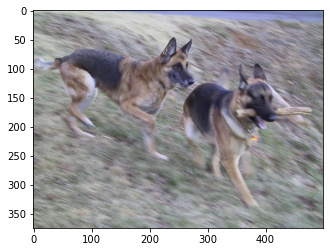

In [2]:

from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # extract features from each photo
    features = dict()
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# load the tokenizer
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
# load the model
model = load_model('model_18.h5')
# load and prepare the photograph
img = mpimg.imread('Sample_images/test1.jpg')
imgplot = plt.imshow(img)
photo = extract_features('Sample_images/test1.jpg')
# generate description
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

Removing startseq and endseq 


In [3]:
query = description
stopwords = ['startseq','endseq']
querywords = query.split()

resultwords  = [word for word in querywords if word.lower() not in stopwords]
result = ' '.join(resultwords)

print(result)

dog is running through the grass


# Assitive Vision with voice command

### Starting the Audio Engine

In [4]:
import pyttsx3
def speak(audio):
    engine = pyttsx3.init()

    engine.say(audio)
    engine.runAndWait()

In [5]:
def takeCommand():
     
    r = sr.Recognizer()
     
    with sr.Microphone() as source:
         
        print("Listening...")
        r.pause_threshold = 1
        audio = r.listen(source)
  
    try:
        print("Recognizing...")   
        query = r.recognize_google(audio, language ='en-in')
        print(f"User said: {query}\n")
  
    except Exception as e:
        print(e)   
        print("Unable to Recognize your voice.") 
        return "None"
     
    return query

## Capturing image from webcam

Execute the cell below, say - "What do you see ?" . And the image would be automatically captured using the webcam and caption(voice) would be generated

Listening...
Recognizing...
User said: what do you see

man in black shirt and white shirt is standing next to an umbrella


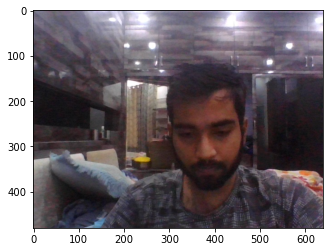

In [7]:
import speech_recognition as sr
from ecapture import ecapture as ec

query = takeCommand().lower()

if query == "what do you see":
    ec.delay_imcapture(0,False,"webcam_image.jpg",5)
    img = mpimg.imread('webcam_image.jpg')
    imgplot = plt.imshow(img)
    photo = extract_features('webcam_image.jpg')
    # generate description
    description = generate_desc(model, tokenizer, photo, max_length)
    query1 = description
    stopwords = ['startseq','endseq']
    querywords = query1.split()

    resultwords  = [word for word in querywords if word.lower() not in stopwords]
    result = ' '.join(resultwords)
    speak(result)
    print(result)
    



## Our model is now ready for deployment